# Text Chunking, Embedding, and Vector Store Indexing

Importing Libraries

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.model_selection import train_test_split
from langchain_text_splitters import RecursiveCharacterTextSplitter
from tqdm import tqdm
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.utils import embedding_functions
import matplotlib.pyplot as plt

Loading the dataset

In [2]:
df = pd.read_csv("/Users/elbethelzewdie/Downloads/rag-complaint-chatbot/rag-complaint-chatbot/data/preprocessed/filtered_complaints.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479473 entries, 0 to 479472
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 479473 non-null  object
 1   Product                       479473 non-null  object
 2   Sub-product                   458854 non-null  object
 3   Issue                         479473 non-null  object
 4   Sub-issue                     315644 non-null  object
 5   Consumer complaint narrative  479473 non-null  object
 6   Company public response       194495 non-null  object
 7   Company                       479473 non-null  object
 8   State                         473927 non-null  object
 9   ZIP code                      479473 non-null  object
 10  Tags                          83801 non-null   object
 11  Consumer consent provided?    479473 non-null  object
 12  Submitted via                 479473 non-null  object
 13 

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,narrative_word_count,Product_category
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,card opened me fraudster. received notice acco...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,91,Credit card
1,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,made mistake using wellsfargo debit card depsi...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,ID,83815,NaN,Consent provided,Web,2025-06-13,Closed with explanation,Yes,NaN,14061897,109,Savings account
2,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,dear cfpb secured credit card citibank changed...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,156,Credit card
3,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,citi reward cards. credit balance issued 8400....,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,233,Credit card
4,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b writing dispute following charge citi credit...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,454,Credit card


### Stratified Sampling

In [4]:
sample_size = 15000  # choose a number between 10k-15k

# Compute stratified proportions
stratify_col = "Product_category"

# Create the stratified sample
strat_sample, _ = train_test_split(
    df,
    train_size=sample_size,
    stratify=df[stratify_col],
    random_state=42
)

# Check the distribution to ensure proportionality
print("Stratified sample distribution:")
print(strat_sample[stratify_col].value_counts(normalize=True).round(3))


Stratified sample distribution:
Product_category
Credit card        0.411
Savings account    0.324
Money transfers    0.206
Personal loan      0.059
Name: proportion, dtype: float64


- I applied proportional stratified sampling based on the product category to create a subset of 15k complaints. This approach preserves the original class distribution observed in the cleaned dataset, ensuring that the embedding space reflects real-world complaint frequencies while maintaining representation from all product categories.

### Text Chunking

In [5]:
# Pick one long complaint for inspection
sample_text = df.loc[
    df["Consumer complaint narrative"].str.len().idxmax(),
    "Consumer complaint narrative"
]

print("Original text length:", len(sample_text))
print(sample_text[:1000])  # preview


Original text length: 22024
consumer fincial protection bureau cfpb dc complain ria high importance high without prejudice wish practice right customer ria use organisation service seeking formal impartial investigation amicably settle dispute ria. order clear myriad letter correspondence hitherto sent ria respecting complaint believe substantially strengthen case understanding taking deeper look happening case alysing relevant fact objective comprehensive fashion. crucial note manipulated socially engineered coerced engage fraudulent crimils. much embarrassment recognise victim investment scam. complaint cfpb arisen not consider stretch imagition conduct ria commensurate legal role responsibility customers. sell service look customer protect money fincial institution maintains traditiol relationship way working customers. complaint process ria found communication ineffective hide conduct magement diminishes service offering clients. struggling adapt business offering ever changing wor

In [6]:
chunk_configs = {
    "300_50": {"chunk_size": 300, "chunk_overlap": 50},
    "500_100": {"chunk_size": 500, "chunk_overlap": 100},
    "800_150": {"chunk_size": 800, "chunk_overlap": 150},
}

In [7]:
for name, config in chunk_configs.items():
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=config["chunk_size"],
        chunk_overlap=config["chunk_overlap"],
        length_function=len
    )

    chunks = splitter.split_text(sample_text)

    print(f"\n{'='*60}")
    print(f"Configuration: chunk_size={config['chunk_size']}, "
          f"chunk_overlap={config['chunk_overlap']}")
    print(f"Number of chunks: {len(chunks)}")

    # Show first 2 chunks only (enough for comparison)
    for i, chunk in enumerate(chunks[:3]):
        print(f"\n--- Chunk {i+1} (length={len(chunk)}) ---")
        print(chunk[:400])



Configuration: chunk_size=300, chunk_overlap=50
Number of chunks: 88

--- Chunk 1 (length=300) ---
consumer fincial protection bureau cfpb dc complain ria high importance high without prejudice wish practice right customer ria use organisation service seeking formal impartial investigation amicably settle dispute ria. order clear myriad letter correspondence hitherto sent ria respecting complaint

--- Chunk 2 (length=295) ---
hitherto sent ria respecting complaint believe substantially strengthen case understanding taking deeper look happening case alysing relevant fact objective comprehensive fashion. crucial note manipulated socially engineered coerced engage fraudulent crimils. much embarrassment recognise victim

--- Chunk 3 (length=293) ---
crimils. much embarrassment recognise victim investment scam. complaint cfpb arisen not consider stretch imagition conduct ria commensurate legal role responsibility customers. sell service look customer protect money fincial institution maint

## Analysis:

#### 300-char chunks:

- Too small. Each chunk contains very little context, so embeddings may not capture the full semantic meaning.

- Retrieval may return multiple chunks for a single complaint because the information is split.

#### 800-char chunks:

- Too long. Each chunk has plenty of context, but the embedding model may struggle with very long text.

- Risk: when a user queries a specific detail, long chunks may include lots of irrelevant content, reducing retrieval precision.

#### 500-char chunks with 100-char overlap: 

- This is the best balance.

- Each chunk is long enough to capture meaningful context, but not so long that embeddings get diluted.

- The 100-char overlap ensures that context is preserved across chunks, so important information that spans chunk boundaries is not lost.

Retrieval will likely be more precise, returning fewer, more relevant chunks per query.

#### Conclusion:
- The 500-char chunk size with 100-char overlap is the optimal choice. It balances context preservation, embedding efficiency, and retrieval precision, which is crucial for your RAG system.

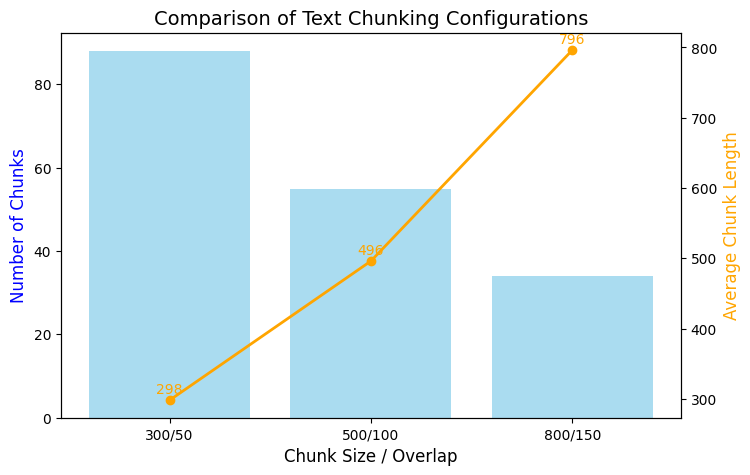

In [9]:
# Chunking configurations and results
configs = ['300/50', '500/100', '800/150']
num_chunks = [88, 55, 34]
avg_chunk_length = [298, 496, 796]

fig, ax1 = plt.subplots(figsize=(8,5))

# Bar plot for number of chunks
ax1.bar(configs, num_chunks, color='skyblue', alpha=0.7)
ax1.set_ylabel('Number of Chunks', color='blue', fontsize=12)
ax1.set_xlabel('Chunk Size / Overlap', fontsize=12)
ax1.set_title('Comparison of Text Chunking Configurations', fontsize=14)

# Line plot for average chunk length
ax2 = ax1.twinx()
ax2.plot(configs, avg_chunk_length, color='orange', marker='o', linewidth=2)
ax2.set_ylabel('Average Chunk Length', color='orange', fontsize=12)

for i, v in enumerate(avg_chunk_length):
    ax2.text(i, v+10, str(v), color='orange', ha='center', fontsize=10)

plt.show()


In [10]:
# Initialize the text splitter with your chosen configuration
chunk_size = 500
chunk_overlap = 100
splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len
)

# Prepare a list to store all chunks with metadata
all_chunks = []

# Loop through each complaint narrative
for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Consumer complaint narrative']
    complaint_id = row['Complaint ID']
    product_category = row['Product_category']

    # Skip empty narratives just in case
    if pd.isna(text) or len(text.strip()) == 0:
        continue

    # Split the text into chunks
    chunks = splitter.split_text(text)

    # Store each chunk with metadata
    for i, chunk in enumerate(chunks):
        all_chunks.append({
            'Complaint ID': complaint_id,
            'Product_category': product_category,
            'chunk_number': i+1,
            'chunk_text': chunk
        })

# Convert the list of chunks into a DataFrame
chunks_df = pd.DataFrame(all_chunks)

# Save the chunks for later embedding and vector store indexing
chunks_df.to_csv("/Users/elbethelzewdie/Downloads/rag-complaint-chatbot/rag-complaint-chatbot/data/preprocessed/complaint_chunks_500_100.csv", index=False)

print(f"Total original complaints: {len(df)}")
print(f"Total chunks generated: {len(chunks_df)}")

100%|██████████| 479473/479473 [01:04<00:00, 7479.11it/s]


Total original complaints: 479473
Total chunks generated: 995771


### Embedding, and Vector Store Indexing

In [12]:
import time
import torch

print(f"Processing {len(chunks_df):,} chunks")

# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

# 1. Compute ALL embeddings first with optimal batching
print("Computing embeddings...")
start_embed = time.time()

embeddings = model.encode(
    chunks_df['chunk_text'].tolist(),
    show_progress_bar=True,
    batch_size=128 if device == 'cuda' else 32,
    convert_to_numpy=True
)

print(f"Embedding time: {(time.time() - start_embed)/60:.2f} minutes")
print(f"Embeddings shape: {embeddings.shape}")

Processing 995,771 chunks
Using device: cpu
Computing embeddings...


Batches: 100%|██████████| 31118/31118 [6:34:28<00:00,  1.31it/s]       


Embedding time: 403.56 minutes
Embeddings shape: (995771, 384)


In [16]:
# 1. Initialize Chroma
client = chromadb.PersistentClient(path="/Users/elbethelzewdie/Downloads/rag-complaint-chatbot/rag-complaint-chatbot/vector_store_new/")

# Clear existing collection if needed
try:
    client.delete_collection("complaint_chunks")
except:
    pass

# 2. Create collection with optimized settings
collection = client.create_collection(
    name="complaint_chunks",
    metadata={"hnsw:space": "cosine"}
)

# 3. Add in batches
batch_size = 5000
total_batches = len(chunks_df) // batch_size + 1

print(f"Adding {len(chunks_df):,} chunks in {total_batches} batches...")
print(f"Batch size: {batch_size}")
start_add = time.time()

# Track successful batches
successful_batches = []

for i in range(0, len(chunks_df), batch_size):
    batch_num = i // batch_size + 1
    batch_start = time.time()

    batch_df = chunks_df.iloc[i:i+batch_size]
    batch_embeddings = embeddings[i:i+batch_size]

    print(f"\nBatch {batch_num}/{total_batches} (chunks {i}:{i+batch_size})", end="")

    try:
        # Convert embeddings to list
        if isinstance(batch_embeddings, np.ndarray):
            embeddings_list = batch_embeddings.tolist()
        else:
            embeddings_list = batch_embeddings

        # Add to collection
        collection.add(
            embeddings=embeddings_list,
            documents=batch_df['chunk_text'].tolist(),
            metadatas=batch_df[['Complaint ID', 'Product_category', 'chunk_number']].to_dict(orient='records'),
            ids=[f"chunk_{idx}" for idx in batch_df.index.tolist()]  # Ensure unique IDs
        )

        batch_time = time.time() - batch_start
        print(f" ✓ ({batch_time:.1f}s)")
        successful_batches.append(batch_num)

        # Show progress every 10 batches
        if batch_num % 10 == 0:
            elapsed_min = (time.time() - start_add) / 60
            print(f"  Progress: {batch_num}/{total_batches} ({batch_num/total_batches*100:.1f}%)")
            print(f"  Elapsed: {elapsed_min:.1f} minutes")

            # Estimate remaining time
            if batch_num > 1:
                avg_time_per_batch = elapsed_min / batch_num
                remaining_batches = total_batches - batch_num
                estimated_remaining = avg_time_per_batch * remaining_batches
                print(f"  Estimated remaining: {estimated_remaining:.1f} minutes")

    except Exception as e:
        print(f"\n❌ Error in batch {batch_num}: {e}")
        print(f"Trying with smaller batch size...")

        # Try with smaller batches
        smaller_batch = 1000
        for j in range(0, len(batch_df), smaller_batch):
            mini_start = j
            mini_end = min(j + smaller_batch, len(batch_df))
            mini_batch_df = batch_df.iloc[mini_start:mini_end]
            mini_batch_embeddings = batch_embeddings[mini_start:mini_end]

            if isinstance(mini_batch_embeddings, np.ndarray):
                mini_embeddings_list = mini_batch_embeddings.tolist()
            else:
                mini_embeddings_list = mini_batch_embeddings

            try:
                collection.add(
                    embeddings=mini_embeddings_list,
                    documents=mini_batch_df['chunk_text'].tolist(),
                    metadatas=mini_batch_df[['Complaint ID', 'Product_category', 'chunk_number']].to_dict(orient='records'),
                    ids=[f"chunk_{idx}_mini_{j//smaller_batch}" for idx in mini_batch_df.index.tolist()]
                )
                print(f"    Mini-batch {j//smaller_batch + 1} ✓")
            except Exception as mini_error:
                print(f"    Mini-batch {j//smaller_batch + 1} failed: {mini_error}")

        print(f"  -> Batch {batch_num} completed in mini-batches")
        successful_batches.append(batch_num)

# Final summary
total_time = (time.time() - start_add) / 60
print(f"\n{'='*60}")
print(f"✅ COMPLETED: {len(successful_batches)}/{total_batches} batches")
print(f"✅ Total insertion time: {total_time:.2f} minutes")
print(f"✅ Total records added: ~{len(successful_batches) * batch_size:,}")
print(f"✅ Total time (embed + insert): {(403.56 + total_time)/60:.1f} hours")
print(f"{'='*60}")

# Verify the collection
print("\nVerifying collection...")
print(f"Collection count: {collection.count()}")

Adding 995,771 chunks in 200 batches...
Batch size: 5000

Batch 1/200 (chunks 0:5000) ✓ (5.6s)

Batch 2/200 (chunks 5000:10000) ✓ (5.1s)

Batch 3/200 (chunks 10000:15000) ✓ (4.8s)

Batch 4/200 (chunks 15000:20000) ✓ (5.7s)

Batch 5/200 (chunks 20000:25000) ✓ (5.3s)

Batch 6/200 (chunks 25000:30000) ✓ (6.0s)

Batch 7/200 (chunks 30000:35000) ✓ (7.0s)

Batch 8/200 (chunks 35000:40000) ✓ (6.1s)

Batch 9/200 (chunks 40000:45000) ✓ (7.0s)

Batch 10/200 (chunks 45000:50000) ✓ (7.2s)
  Progress: 10/200 (5.0%)
  Elapsed: 1.0 minutes
  Estimated remaining: 18.9 minutes

Batch 11/200 (chunks 50000:55000) ✓ (6.8s)

Batch 12/200 (chunks 55000:60000) ✓ (6.9s)

Batch 13/200 (chunks 60000:65000) ✓ (8.2s)

Batch 14/200 (chunks 65000:70000) ✓ (59.4s)

Batch 15/200 (chunks 70000:75000) ✓ (30.4s)

Batch 16/200 (chunks 75000:80000) ✓ (51.1s)

Batch 17/200 (chunks 80000:85000) ✓ (27.0s)

Batch 18/200 (chunks 85000:90000) ✓ (17.1s)

Batch 19/200 (chunks 90000:95000) ✓ (17.6s)

Batch 20/200 (chunks 95000:100